## Hydraulic Fracturing in the Toughness-Dominated Regime


Under the toughness-dominated regime without leak-off, the fluid viscosity dissipation is negligible compared to the energy released for fracture surface formation (**Detournay _et al._, 2016**). Therefore, in this regime, we can neglect the pressure loss within the fracture and use the Sneddon solution for crack opening (**Bourdin _et al._, 2012**, **Sneddon et al., 1969**) to determine the pressure and length evolution.

The work of the pressure force is as follows:

$$
\begin{equation}
\mathcal{W}(R) =\frac{2 p^2 a^2}{E'}.
\end{equation}
$$

Applying Clapeyron's theorem, the elastic energy can be determined as

$$
\begin{equation}
\mathcal{E}(R) =-\frac{\pi p^2 a^2}{E'},
\end{equation}
$$
and the energy release rate with respect to the crack length $a$ propagating along the initial inclination is
$$
\begin{equation}
G(R) = - \frac{\partial \mathcal{E}}{\partial (2 a)} = \frac{\pi p^2 a}{E'}.
\end{equation}
$$

Griffith\'s criterion (**Griffith _et al._, 1920**) states that the fracture propagates when $G=G_c$ and the critical volume for crack propagation is $V_c := \sqrt{\dfrac{4 \pi G_c a^3}{E' }}$ in a quasi-static volume control setting (the fracture propagation is always unstable with pressure control).


The evolution of the corresponding pressure and fracture length
$$
\begin{equation}
p(V) =
\begin{cases}
\dfrac{E' V}{2 \pi a_0^2} &\text{for} V <  V_c \\
\left[  \dfrac{2 E' G_c^2}{\pi V} \right] ^{\frac{1}{3}}&\text{for}    V \geq V_c,
\end{cases}
\end{equation}
$$

$$
\begin{equation}
a(V) =
\begin{cases}
a_0 & V <  V_c \\
\left[ \dfrac{E' V^2}{4 \pi G_c} \right ] ^{\frac{1}{3}} &    V \geq V_c.
\end{cases}
\end{equation}
$$

# Problem Description

Based on Sneddon\'s solution (**Sneddon et al., 1969**), we verified the model with plane-strain hydraulic fracture propagation in a toughness-dominated regime. In an infinite 2D domain, the problem was solved with a line fracture $[-a_0, a_0] \times \{0\}$ ($a_0$ = 0.05). We considered a large finite domain $[-40a_0,40a_0] \times [-40a_0,40a_0]$ to account for the infinite boundaries in the closed-form solution. The effective size of an element, $h$, is $1\times10^{-2}$.

![Schematic view of hydraulic fracturing problem and Boundary conditions](./figures/Model_propagating_straight.png#one-half "Schematic view of hydraulic fracturing problem and Boundary conditions.")

* In order to  have the hydraulic fracturing in the toughness dominated-regime, add, $\texttt{<pressurized_crack_scheme>propagating</pressurized_crack_scheme>}$ in the project file.
* **Yoshioka _et al._, 2019**  provides additional information on the implementation, use of real material properties, and rescaling of the phase-field energy functional.


# Input Data

Taking advantage of the linearity of the system, the simulations were run with the dimensionless properties listed in the Table below.

| **Name**                       | **Value**         | **Symbol** |
|--------------------------------|------------------ |------------|
| _Young's modulus_              | 1                 | $E$        |
| _Poisson's ratio_              | 0.15              | $\nu$      |
| _Fracture toughness_           | 1                 | $G_{c}$    |
| _Regularization parameter_     | 2$h$              | $\ell_s$   |
| _Length_                       | 4                 | $L$        |
| _Height_                       | 4                 | $H$        |
| _Initial crack length_         | 0.1               | $2a_0$     |

In [1]:
import math
import os
import re
import time

import gmsh
import matplotlib.pyplot as plt
import numpy as np
from ogs6py import ogs
from ogstools.msh2vtu import msh2vtu

pi = math.pi
plt.rcParams["text.usetex"] = True

In [2]:
E = 1.0
nu = 0.15
Gc = 1.0
h = 0.01
a0 = 0.05  # half of the initial crack length

phasefield_model = "AT1"  # AT1/AT2

# Output Directory  and Project File

In [3]:
# file's name
prj_name = "Kregime_Propagating.prj"
meshname = "mesh_full_pf"

from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Mesh Generation


In [25]:
def mesh_generation(lc, lc_fine):
    """
    lc ... characteristic length for coarse meshing
    lc_fine ... characteristic length for fine meshing
    """
    L = 4.0  # Length
    H = 4.0  # Height
    b = 0.4  # Length/Height of subdomain with fine mesh

    # Before using any functions in the Python API, Gmsh must be initialized
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("rectangle")

    # Dimensions
    dim0 = 0
    dim1 = 1
    dim2 = 2

    # Points
    gmsh.model.geo.addPoint(-L / 2, -H / 2, 0, lc, 1)
    gmsh.model.geo.addPoint(L / 2, -H / 2, 0, lc, 2)
    gmsh.model.geo.addPoint(L / 2, H / 2, 0, lc, 3)
    gmsh.model.geo.addPoint(-L / 2, H / 2, 0, lc, 4)
    gmsh.model.geo.addPoint(-b, -b - lc_fine / 2, 0, lc_fine, 5)
    gmsh.model.geo.addPoint(b, -b - lc_fine / 2, 0, lc_fine, 6)
    gmsh.model.geo.addPoint(b, b + lc_fine / 2, 0, lc_fine, 7)
    gmsh.model.geo.addPoint(-b, b + lc_fine / 2, 0, lc_fine, 8)

    # Lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    gmsh.model.geo.addLine(5, 6, 5)
    gmsh.model.geo.addLine(6, 7, 6)
    gmsh.model.geo.addLine(7, 8, 7)
    gmsh.model.geo.addLine(8, 5, 8)

    # Line loops
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 2)

    # Add plane surfaces defined by one or more curve loops.
    gmsh.model.geo.addPlaneSurface([1, 2], 1)
    gmsh.model.geo.addPlaneSurface([2], 2)

    gmsh.model.geo.synchronize()

    # Prepare structured grid
    gmsh.model.geo.mesh.setTransfiniteCurve(
        6, math.ceil(2 * b / lc_fine + 2), "Progression", 1
    )
    gmsh.model.geo.mesh.setTransfiniteCurve(
        8, math.ceil(2 * b / lc_fine + 2), "Progression", 1
    )
    gmsh.model.geo.mesh.setTransfiniteSurface(2, "Alternate")

    gmsh.model.geo.mesh.setRecombine(dim2, 1)
    gmsh.model.geo.mesh.setRecombine(dim2, 2)

    gmsh.model.geo.synchronize()

    # Physical groups
    P1 = gmsh.model.addPhysicalGroup(dim0, [1])
    gmsh.model.setPhysicalName(dim0, P1, "P1")

    P2 = gmsh.model.addPhysicalGroup(dim0, [2])
    gmsh.model.setPhysicalName(dim0, P2, "P2")

    Bottom = gmsh.model.addPhysicalGroup(dim1, [1])
    gmsh.model.setPhysicalName(dim1, Bottom, "Bottom")

    Right = gmsh.model.addPhysicalGroup(dim1, [2])
    gmsh.model.setPhysicalName(dim1, Right, "Right")

    Top = gmsh.model.addPhysicalGroup(dim1, [3])
    gmsh.model.setPhysicalName(dim1, Top, "Top")

    Left = gmsh.model.addPhysicalGroup(dim1, [4])
    gmsh.model.setPhysicalName(dim1, Left, "Left")

    Computational_domain = gmsh.model.addPhysicalGroup(dim2, [1, 2])
    gmsh.model.setPhysicalName(dim2, Computational_domain, "Computational_domain")
    gmsh.model.geo.synchronize()

    output_file = f"{out_dir}/" + meshname + ".msh"
    gmsh.model.mesh.generate(dim2)
    gmsh.write(output_file)
    gmsh.finalize()

# Pre-Processing

In [26]:
def pre_processing(h, a0):
    mesh = pv.read(f"{out_dir}/mesh_full_pf_domain.vtu")
    phase_field = np.ones((len(mesh.points), 1))
    pv.set_plot_theme("document")

    for node_id, x in enumerate(mesh.points):
        if (
            (mesh.center[0] - x[0]) <= a0 + 0.001 * h
            and (mesh.center[0] - x[0]) >= -a0 - 0.001 * h
            and (mesh.center[1] - x[1]) < h / 2 + 0.001 * h
            and (mesh.center[1] - x[1]) > -h / 2 - 0.001 * h
        ):
            phase_field[node_id] = 0.0

    mesh.point_data["phase-field"] = phase_field
    mesh.save(f"{out_dir}/mesh_full_pf_OGS_pf_ic.vtu")

# Run the Simulation


In [27]:
import pyvista as pv

pv.set_plot_theme("document")
if "PYVISTA_HEADLESS" in os.environ:
    pv.start_xvfb()
pv.set_jupyter_backend("static")


def Hydraulic_Fracturing_Toughness_Dominated_numerical(h, phasefield_model):
    # mesh properties
    ls = 2 * h
    # generate prefix from properties
    filename = f"results_h_{h:0.4f}_{phasefield_model}"
    mesh_generation(0.1, h)
    # Convert GMSH (.msh) meshes to VTU meshes appropriate for OGS simulation.
    input_file = f"{out_dir}/" + meshname + ".msh"
    msh2vtu(filename=input_file, output_path=out_dir, reindex=True, keep_ids=True)
    %cd {out_dir}
    ! identifySubdomains -f -m mesh_full_pf_domain.vtu -- mesh_full_pf_physical_group_*.vtu
    %cd -

    # As a preprocessing step, define the initial phase-field (crack).
    pre_processing(h, a0)
    # change properties in prj file #For more information visit: https://github.com/joergbuchwald/ogs6py
    model = ogs.OGS(
        INPUT_FILE=prj_name,
        PROJECT_FILE=f"{out_dir}/{prj_name}",
        MKL=True,
        args=f"-o {out_dir}",
    )
    model.replace_parameter_value(name="ls", value=ls)
    model.replace_text(phasefield_model, xpath="./processes/process/phasefield_model")
    model.replace_text(filename, xpath="./time_loop/output/prefix")
    model.write_input()
    # run simulation with ogs
    t0 = time.time()
    print(">>> OGS started execution ... <<<")
    ! ogs {out_dir}/{prj_name} -o {out_dir} > {out_dir}/log.txt
    tf = time.time()
    print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

In [28]:
Hydraulic_Fracturing_Toughness_Dominated_numerical(h, phasefield_model)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.00119501s, CPU 0.001505s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [  0%] Blossom: 24032 internal 482 closed
Info    : [  0%] Blossom recombination completed (Wall 0.410523s, CPU 0.409133s): 7878 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.793024, min Q = 0.371315
Info    : [ 50%] Meshing surface 2 (Transfinite)
Info    : Done meshing 2D (Wall 0.651176s, CPU 0.644329s)
Info    : 14439 nodes 14848 elements
Info    : Writing '_out/mesh_full_pf.msh'...
Info    : Done writing '_out/mesh_full_pf.msh'
Output: _out/mesh_full_pf

Original mesh (

# Post-Processing

## Analytical Solution for the Evolution of Fracture Length and Pressure

In [29]:
def Analytical_solution(phasefield_model, h):
    v = np.linspace(1e-10, 0.3, 31)
    pres = np.linspace(0, 1.0, 31)
    length = np.linspace(0, 1.0, 31)

    ls = 2 * h

    # Effective Gc and a for AT1/A2
    if phasefield_model == "AT1":
        Gc_ref = Gc * (3 * h / 8.0 / ls + 1.0)
        a_eff = a0 * (1 + pi * ls / (4.0 * a0 * (3 * h / 8.0 / ls + 1.0)))
    elif phasefield_model == "AT2":
        Gc_ref = Gc * (h / (2.0 * ls) + 1.0)
        a_eff = a0 * (1 + pi * ls / (4.0 * a0 * (h / (2.0 * ls) + 1.0)))

    Eprime = E / (1 - nu**2)

    V_c = (4 * pi * Gc_ref * a_eff**3 / Eprime) ** 0.5
    P_c = (Eprime * Gc_ref / (pi * a_eff)) ** 0.5

    for i in range(len(v)):
        if v[i] < V_c:
            pres[i] = Eprime * v[i] / (2 * pi * a_eff**2) / P_c
            length[i] = a_eff
        else:
            pres[i] = (2 * Eprime * Gc_ref**2 / (pi * v[i])) ** 0.333333 / P_c
            length[i] = (Eprime * v[i] ** 2 / (4 * pi * Gc_ref)) ** 0.333333

    return v, pres, length, Gc_ref, P_c


fluidVolume_analytical = Analytical_solution(phasefield_model, h)[0]
pressure_analytical = Analytical_solution(phasefield_model, h)[1]
length_analytical = Analytical_solution(phasefield_model, h)[2]
Gc_ref = Analytical_solution(phasefield_model, h)[3]
P_c = Analytical_solution(phasefield_model, h)[4]

## Phase Field Versus Analytical Solution for Fracture Length and Pressure Evolution

In phase field approach, we can retrieve the crack length $a$ as:

$$
\begin{equation}
	a = \dfrac{\displaystyle \int_\Omega \frac{G_c}{4 c_n} \left(\frac{(1-v)^n}{\ell}+ \ell |\nabla v|^2\right)\,\mathrm{d} \Omega }{G_c  \left( \dfrac{h}{4 c_n \ell} + 1 \right)}.
\end{equation}
$$
where $n=1$ corresponds to $\texttt{AT}_1$ ($c_n = 2/3$) and $n=2$ to $\texttt{AT}_2$ ($c_n = 1/2$).

/tmp/ipykernel_2977068/1796410303.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


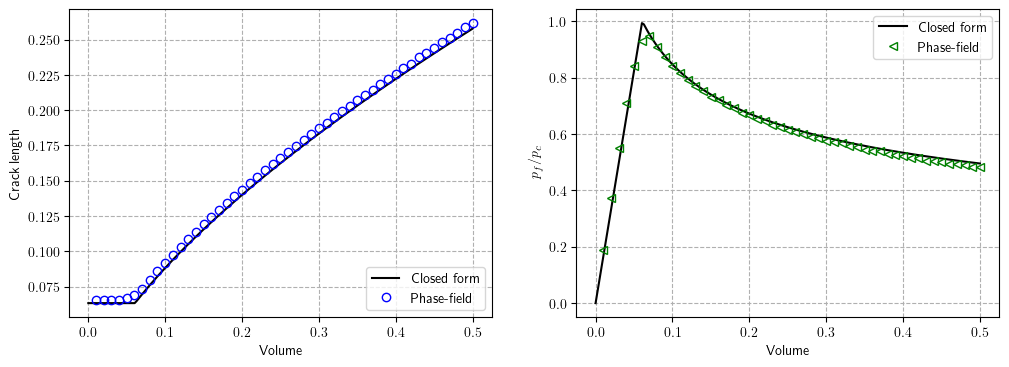

In [30]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
fluid_volume = []
surface_energy = []
# Open the file for reading
with (out_dir / "log.txt").open() as fd:
    # Iterate over the lines
    for _i, line in enumerate(fd):
        match_surface_energy = re.search(
            r"""Surface energy: (\d+\.\d*) Pressure work: (\d+\.\d*)  at time: (\d+\.\d*)""",
            line,
        )
        if match_surface_energy:
            surface_energy.append(float(match_surface_energy.group(1)))
            fluid_volume.append(float(match_surface_energy.group(3)))

plt.grid(linestyle="dashed")
plt.xlabel("Volume")
plt.ylabel("Crack length")
plt.plot(fluidVolume_analytical, length_analytical, "black", label="Closed form")
plt.plot(
    fluid_volume,
    np.array(surface_energy[:]) / Gc_ref / 2,
    "bo",
    fillstyle="none",
    label="Phase-field",
)
legend = plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
fluid_volume = []
pressure = []
# Open the file for reading
with (out_dir / "log.txt").open() as fd:
    # Iterate over the lines
    for _i, line in enumerate(fd):
        match_pressure = re.search(
            r"""Pressure: (\d+\.\d*) at time: (\d+\.\d*)""", line
        )
        if match_pressure:
            fluid_volume.append(float(match_pressure.group(2)))
            pressure.append(float(match_pressure.group(1)))


plt.xlabel("Volume")
plt.ylabel("$p_f/p_c$")
plt.plot(fluidVolume_analytical, pressure_analytical, "black", label="Closed form")
plt.plot(
    np.array(fluid_volume[:]),
    np.array(pressure[:]) / P_c,
    "g<",
    fillstyle="none",
    label="Phase-field",
)
plt.grid(linestyle="dashed")
legend = plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.grid(linestyle="dashed")
plt.plot(
    fluidVolume_analytical[1:],
    (
        abs(length_analytical[1:] - np.array(surface_energy[:]) / (2 * Gc_ref))
        / (np.array(surface_energy[:]) / (2 * Gc_ref))
    )
    * 100,
    "-.ob",
    fillstyle="none",
    label="Closed form",
)
plt.ylim([0.0, 10])
plt.xlabel("Volume")
plt.ylabel(
    r"$\frac{|a_\mathrm{num}-{a}_\mathrm{ana}|}{{a}_\mathrm{num}}\times 100\%$",
    fontsize=14,
)

plt.subplot(1, 2, 2)
plt.grid(linestyle="dashed")
plt.plot(
    fluidVolume_analytical[1:],
    (abs(pressure_analytical[1:] - np.array(pressure[:]) / P_c) / pressure[:]) * 100,
    "-.<g",
    fillstyle="none",
    label="Closed form",
)
plt.ylim([0.0, 10])
plt.xlabel("Volume")
plt.ylabel(
    r"$\frac{|p_\mathrm{num}-{p}_\mathrm{ana}|}{{p}_\mathrm{num}}\times 100\%$",
    fontsize=14,
)
plt.show()

In order to reduce computation time, we perform the simulation with a coarse mesh; the results for the $\texttt{AT}_1$ Model with a mesh size of $h=0.001$ are provided below.

$\texttt{AT}_1$ Model:

![Phase field versus analytical solution for fracture length and pressure evolution](./figures/AT1_VolDev_h0p001.png#one-half "Phase field versus analytical solution for fracture length and pressure evolution, $\texttt{AT}_1$.")

![Error between the Phase field and analytical solution for fracture length and pressure evolution.](./figures/error_AT1_VolDev_h0p001.png#one-half "Error between the Phase field and analytical solution for fracture length and pressure evolution, $\texttt{AT}_1$.")

## Hydraulic Fracturing Animation  (Using Phase Field Approach)

In [4]:
import pyvista as pv

pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

In [5]:
filename = f"results_h_{h:0.4f}_{phasefield_model}"
reader = pv.get_reader(f"{out_dir}/" + filename + ".pvd")

plotter = pv.Plotter(shape=(1, 2), border=False)
plotter.open_gif(f"{out_dir}/Kregime_Propagating.gif")
for time_value in reader.time_values:
    reader.set_active_time_value(time_value)
    mesh = reader.read()[0]
    sargs = {
        "title": "Phase field",
        "title_font_size": 16,
        "label_font_size": 12,
        "n_labels": 5,
        "position_x": 0.25,
        "position_y": 0.15,
        "fmt": "%.1f",
        "width": 0.5,
    }
    p = pv.Plotter(shape=(1, 2), border=False)
    clim = [0, 1.0]
    points = mesh.point_data["phasefield"].shape[0]
    xs = mesh.points[:, 0]
    ys = mesh.points[:, 1]
    pf = mesh.point_data["phasefield"]
    plotter.clear()
    plotter.add_mesh(
        mesh,
        scalars=pf,
        show_scalar_bar=True,
        colormap="coolwarm",
        clim=clim,
        scalar_bar_args=sargs,
        lighting=False,
    )
    plotter.add_text(f"Time: {time_value:0.02f}", color="black")

    plotter.view_xy()
    plotter.write_frame()

plotter.close()

## Phase Field Profile at Last Time Step

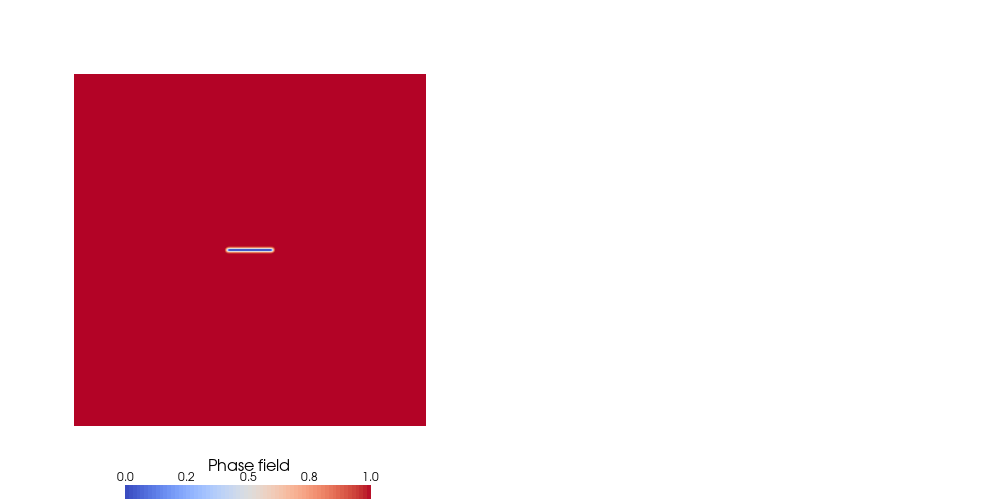

In [6]:
mesh = reader.read()[0]

points = mesh.point_data["phasefield"].shape[0]
xs = mesh.points[:, 0]
ys = mesh.points[:, 1]
pf = mesh.point_data["phasefield"]

clim = [0, 1.0]
sargs = {
    "title": "Phase field",
    "title_font_size": 16,
    "label_font_size": 12,
    "n_labels": 5,
    "position_x": 0.25,
    "position_y": 0.0,
    "fmt": "%.1f",
    "width": 0.5,
}
plotter = pv.Plotter(shape=(1, 2), border=False)
plotter.add_mesh(
    mesh,
    scalars=pf,
    show_edges=False,
    show_scalar_bar=True,
    colormap="coolwarm",
    clim=clim,
    scalar_bar_args=sargs,
    lighting=False,
)

plotter.view_xy()
plotter.camera.zoom(1.5)
plotter.window_size = [1000, 500]
plotter.show()

## References

[1] Detournay, Emmanuel. _Mechanics of hydraulic fractures._ Annual review of fluid mechanics 48 (2016): 311-339.

[2] Bourdin, Blaise, Chukwudi Chukwudozie, and Keita Yoshioka. _A variational approach to the numerical simulation of hydraulic fracturing._ In SPE annual technical conference and exhibition. OnePetro, 2012.

[3] Sneddon, Ian Naismith, and Morton Lowengrub. _Crack problems in the classical theory of elasticity._ 1969, 221 P (1969).

[4] Griffith, Alan Arnold. _VI. The phenomena of rupture and flow in solids._ Philosophical transactions of the royal society of london. Series A, containing papers of a mathematical or physical character 221, no. 582-593 (1921): 163-198.

[5] Yoshioka, Keita, Francesco Parisio, Dmitri Naumov, Renchao Lu, Olaf Kolditz, and Thomas Nagel. _Comparative verification of discrete and smeared numerical approaches for the simulation of hydraulic fracturing._ GEM-International Journal on Geomathematics 10, no. 1 (2019): 1-35.
